<a href="https://colab.research.google.com/github/halcy/tpuddim/blob/main/TPU_DDIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPU DDIM Colab notebook

In [ ]:
# Catchall "what is this runtime" cell
!nvidia-smi
GPU = !nvidia_smi

if len(GPU) > 3:
    GPU = True
else:
    GPU = False

!vmstat
print("")

import os

if "COLAB_TPU_ADDR" in os.environ:
    from tensorflow.python.profiler import profiler_client
    print("tpu:", os.environ['COLAB_TPU_ADDR'])
    tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
    print(profiler_client.monitor(tpu_profile_service_address, 100, 2).strip())
    TPU = True
else:
    print("tpu: no")
    TPU = False

CPUS = os.cpu_count()
print("\ncpus:", CPUS)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

procs -----------memory---------- ---swap-- -----io---- -system-- ------cpu-----
 r  b   swpd   free   buff  cache   si   so    bi    bo   in   cs us sy id wa st
 1  0      0 33493092 107240 2394784    0    0    53     2   26  325  0  0 100  0  0

tpu: 10.14.51.178:8470
Timestamp: 16:53:24
  TPU type: TPU v2
  Utilization of TPU Matrix Units (higher is better): 0.000%

cpus: 40


# Basic setup

Set up TPU, import libraries

In [ ]:
# Set JAX, flax and optax up for the TPU
!pip install --upgrade -q jax jaxlib optax tqdm
!pip install --upgrade flax

import requests
import os

if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

# TPU driver as backend for JAX
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import math

import jax
import jax.numpy as jnp
from jax import jit, lax
from jax import nn as jnn
from jax import random as jr
import functools

import flax
import flax.linen as nn
from flax.core import freeze, unfreeze

from typing import Any, Callable, Sequence, Optional

from jax.experimental.maps import xmap, mesh
from jax.experimental.pjit import pjit, PartitionSpec
from jax.experimental import stax

import optax
import tqdm

import pickle

# Pinky promise: We are now aware xmap is experimental, and will adjust our expectations accordingly
import warnings
warnings.filterwarnings("ignore", message="xmap is an experimental feature and probably has bugs!")

In [ ]:
# Generate PRNG state
prng = jr.PRNGKey(23)

# Blocks for a diffusion model

### Timestep embedding, block sequencing

In [ ]:
class TimeEmbed(nn.Module):
    """
    Timestep embedding module
    """
    time_embed_dim: int
    max_period: int
    project_embed_dim: int
    embed_dtype: jnp.dtype = jnp.float32

    @nn.compact
    def __call__(self, timesteps):
        # Calculate sinusodial embedding
        half = self.time_embed_dim // 2
        freqs = jnp.exp(-math.log(self.max_period) * jnp.arange(0, half) / half)
        args = timesteps[:, None].astype(self.embed_dtype) * freqs[None]
        embedding = jnp.concatenate([jnp.cos(args), jnp.sin(args)], axis = -1)
        if self.time_embed_dim % 2:
            embedding = jnp.concatenate([embedding, jnp.zeros(embedding[:, :1].shape)], axis = -1)

        # Some dense layers to properly embed for real
        embedding = nn.Dense(self.project_embed_dim)(embedding)
        embedding = nn.silu(embedding)
        embedding = nn.Dense(self.project_embed_dim)(embedding)
        
        return embedding

class TimestepBlock(nn.Module):
    """
    Interface for modules that can take timestep embeddings as input
    in addition to regular embeddings.
    """
    def __call__(self, x, emb):
        pass

class TimestepEmbedSequential(TimestepBlock):
    """
    Block that passes timestep embeddings to all submodules that
    want them.

    Also works as a regular sequential type module
    """
    layers: Sequence[nn.Module]

    @nn.compact
    def __call__(self, x, emb = None):
        for layer in self.layers:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

class TimestepBlockTest(TimestepBlock):
    """
    Dummy block for testing
    """
    @nn.compact
    def __call__(self, x, emb):
        return x

In [ ]:
# Lets see if it works
"""
embed_test = TimeEmbed(16, 10000, 16 * 4)
embed_in = jnp.zeros((10, 1))
params = embed_test.init(prng, embed_in)
embed_test.apply(params, embed_in).shape
"""

'\nembed_test = TimeEmbed(16, 10000, 16 * 4)\nembed_in = jnp.zeros((10, 1))\nparams = embed_test.init(prng, embed_in)\nembed_test.apply(params, embed_in).shape\n'

### Convolution, pooling and identity

In [ ]:
class ConvND(nn.Module):
    """
    n-D convolution with square kernel
    """
    dims: int
    out_channels: int
    kernel_size: int
    stride: int = 1
    padding: int = 'SAME'

    def setup(self):
        self.kernel = tuple([self.kernel_size] * self.dims)
        self.strides = tuple([self.stride] * self.dims)
        if self.padding in ['SAME', 'VALID']:
            self.paddings = self.padding
        else:
            self.paddings = tuple([(self.padding, self.padding)] * self.dims)
        self.conv = nn.Conv(self.out_channels, self.kernel, self.strides, self.paddings)

    def __call__(self, x):
        return self.conv(x)

class AvgND(nn.Module):
    """
    n-D average pooling with square window

    Numeric padding is NOT supported, specify either SAME or VALID padding.
    """
    dims: int
    window_size: int = 2
    stride: int = 2
    padding: int = 'VALID'

    def setup(self):
        self.window = [1] + [self.window_size] * self.dims
        self.strides = [1] + [self.stride] * self.dims
        if self.padding in ['SAME', 'VALID']:
            self.paddings = self.padding

    def __call__(self, x):
        full_window = tuple(list(self.window) + list([1] * (len(x.shape) - len(self.window) - 1)))
        full_strides = tuple(list(self.strides) + list([1] * (len(x.shape) - len(self.window) - 1)))
        return nn.avg_pool(x, full_window, full_strides, self.paddings)

class Identity(nn.Module):
  """
  For model building convenience, a class that does nothing
  """
  @nn.compact
  def __call__(self, x):
      return x

### Up- and Downsampling

In [ ]:
class Scale2X(nn.Module):
  """
  nD 2x nearest neighbour scaling
  """
  dims: int
  
  @nn.compact
  def __call__(self, x):
      for i in range(1, self.dims + 1):
          x = jnp.repeat(x, 2, axis = i)
      return x

class Upsample(nn.Module):
    """
    Upsampling layer, factor 2

    Nearest neighour (element repeating), optionally with a convolution afterwards.
    """
    dims: int
    out_channels: int = 0
    use_conv: bool = False

    def setup(self):
        self.scale = Scale2X(self.dims)
        if self.use_conv:
            assert self.out_channels != 0
            self.conv = ConvND(self.dims, self.out_channels, 3)
        else:
            self.conv = Identity()

    def __call__(self, x):
        x = self.scale(x)
        x = self.conv(x)
        return x

class Downsample(nn.Module):
    """
    Downsampling layer, factor 2

    Uses either average pooling (default) or a strided convolution.
    """
    dims: int
    out_channels: int = 0
    use_conv: bool = False

    def setup(self):
        if self.use_conv:
            assert self.out_channels != 0
            self.downsample = ConvND(self.dims, self.out_channels, 3, stride=2, padding=1)
        else:
            self.downsample = AvgND(self.dims)

    def __call__(self, x):
        x = self.downsample(x)
        return x

### Residual block

In [ ]:
class ResBlock(TimestepBlock):
    """
    Residual block with timesteps
    """
    dims: int
    in_channels: int
    out_channels: int
    dropout: float
    use_conv: bool = False
    up: bool = False
    down: bool = False
    use_scale_shift_norm: bool = False

    def setup(self):
        # Initial normalization block
        self.in_block = TimestepEmbedSequential((
            nn.GroupNorm(epsilon=1e-05),
            nn.silu,
        ))

        # Up/Downsampling block
        if self.up:
            self.h_upd = Upsample(self.dims) 
            self.x_upd = Upsample(self.dims)
        elif self.down:
            self.h_upd = Downsample(self.dims)
            self.x_upd = Downsample(self.dims)
        else:
            self.h_upd = self.x_upd = Identity()

        # Input convolution
        self.in_conv = ConvND(self.dims, self.out_channels, 3)

        # Embedding projection block
        self.embed_project = TimestepEmbedSequential((
            nn.silu,
            nn.Dense(2 * self.out_channels if self.use_scale_shift_norm else self.out_channels)
        ))

        # Actual layer stack
        self.out_norm = nn.GroupNorm(epsilon=1e-05)
        self.out_layers = TimestepEmbedSequential((
            nn.silu,
            nn.Dropout(self.dropout, deterministic=True), # TODO: This should be dynamic, for training. Right now it's a noop.
            ConvND(self.dims, self.out_channels, 3) # There was a zero initializer (?) here, it's gone now, sorry. Maybe not important.
        ))

        # Channel change for skip connection
        if self.out_channels == self.in_channels:
            self.skip_connection = Identity()
        elif self.use_conv:
            self.skip_connection = ConvND(self.dims, self.out_channels, 3)
        else:
            self.skip_connection = ConvND(self.dims, self.out_channels, 1)

    def __call__(self, x, emb):
        # For residual: Resample x
        x_res = self.x_upd(x)

        # Run x through input & up/downsample block
        x = self.in_block(x)
        x = self.h_upd(x)
        x = self.in_conv(x)
            
        # Project embedding and unsqueeze up to match shape of x
        emb_out = self.embed_project(emb.reshape(emb.shape[0], -1))
        emb_out = emb_out.reshape((emb_out.shape[0],) + tuple([1] * (len(x.shape) - len(emb_out.shape))) + (emb_out.shape[-1],))
        
        # Apply actual convolution
        if self.use_scale_shift_norm:
            scale = emb_out[..., :self.out_channels]
            shift = emb_out[..., self.out_channels:]
            x = self.out_norm(x) * (1 + scale) + shift
            x = self.out_layers(x)
        else:
            x = x + emb_out
            x = self.out_norm(x)
            x = self.out_layers(x)

        # Return residual
        return self.skip_connection(x_res) + x

In [ ]:
# Lets see if it works
"""
conv = ResBlock(2, 64, 128, .5, up=True, use_conv=False, use_scale_shift_norm=True)
conv_in = jnp.zeros((10, 20, 20, 64))
params = conv.init(prng, conv_in, conv_in)
conv.apply(params, conv_in, conv_in).shape
"""

'\nconv = ResBlock(2, 64, 128, .5, up=True, use_conv=False, use_scale_shift_norm=True)\nconv_in = jnp.zeros((10, 20, 20, 64))\nparams = conv.init(prng, conv_in, conv_in)\nconv.apply(params, conv_in, conv_in).shape\n'

### Attention block

In [ ]:
class SpatialSelfAttentionBlock(nn.Module):
    """
    Dot-product attention block for spatial dimensions
    """
    head_channels: int = 64
    
    @nn.compact
    def __call__(self, x):
        # Flatten out spatial channels and norm
        batches = x.shape[0]
        channels = x.shape[-1]
        x_in = x.reshape((batches, -1, channels))
        qkv = nn.GroupNorm(epsilon=1e-05)(x_in)

        # Convolve to three times the amount of channels and split into query, key and value
        qkv = ConvND(1, channels * 3, 1)(qkv)

        # Calculate number of heads and split into heads
        heads = int(channels / self.head_channels)
        qkv = qkv.reshape(batches, -1, heads, self.head_channels * 3)

        # Split into query/key/value
        query = qkv[:, :, :, 0:self.head_channels] 
        key = qkv[:, :, :, self.head_channels:self.head_channels*2]
        value = qkv[:, :, :, self.head_channels*2:]

        # Calculate dot product attention and flatten out
        x_out = nn.dot_product_attention(query, key, value, deterministic=True)
        x_out = x_out.reshape((batches, -1, channels))

        # Project
        x_out = ConvND(1, channels, 1)(x_out)

        # Resicual and reshape back to original shape
        return (x_in + x_out).reshape(x.shape)

In [ ]:
# Lets see if it works
"""
attention = SpatialSelfAttentionBlock(64)
attention_in = jnp.zeros((10, 20, 30, 256))
params = attention.init(prng, attention_in)
attention.apply(params, attention_in).shape
"""

'\nattention = SpatialSelfAttentionBlock(64)\nattention_in = jnp.zeros((10, 20, 30, 256))\nparams = attention.init(prng, attention_in)\nattention.apply(params, attention_in).shape\n'

# The actual model


In [ ]:
class UNet(nn.Module):
    """
    Unet style model with spatial self attention.
    Unconditional only, for now.
    """
    dims: int
    model_channels: int
    channel_mult: int
    use_scale_shift_norm: bool
    dropout: float
    num_head_channels: int
    num_res_blocks: int
    attention_resolutions: Sequence[int]
    out_channels: int

    def setup(self):
        # Timestep embedding
        time_embed_dim = self.model_channels * 4
        self.time_embed = TimeEmbed(self.model_channels, 10000, time_embed_dim)

        # Initial block for input stack
        input_block_out_channels = int(self.channel_mult[0] * self.model_channels)
        input_blocks = [TimestepEmbedSequential([ConvND(self.dims, input_block_out_channels, 3, padding = 1)])]

        # Loop to create rest of input stack
        current_channels = input_ch = int(self.channel_mult[0] * self.model_channels)
        input_block_chans = [current_channels]
        downsample_fact = 1
        for level, mult in enumerate(self.channel_mult):
            for _ in range(self.num_res_blocks):
                # One res block
                layers = [ResBlock(self.dims, current_channels, int(mult * self.model_channels), dropout = self.dropout, use_scale_shift_norm = self.use_scale_shift_norm)]
                current_channels = int(mult * self.model_channels)

                # One attention block, if requested
                if downsample_fact in self.attention_resolutions:
                    layers.append(SpatialSelfAttentionBlock(self.num_head_channels))

                # Put those in sequence
                input_blocks.append(TimestepEmbedSequential(layers))
                input_block_chans.append(current_channels)

            # Downsample if not the final block
            if level != len(self.channel_mult) - 1:
                input_blocks.append(ResBlock(self.dims, current_channels, current_channels, dropout = self.dropout, use_scale_shift_norm = self.use_scale_shift_norm, down = True))
                input_block_chans.append(current_channels)
                downsample_fact *= 2             
        self.input_blocks = input_blocks

        # Middle block
        self.middle_block = TimestepEmbedSequential([
            ResBlock(self.dims, current_channels, current_channels, self.dropout, use_scale_shift_norm = self.use_scale_shift_norm),
            SpatialSelfAttentionBlock(self.num_head_channels),
            ResBlock(self.dims, current_channels, current_channels, self.dropout, use_scale_shift_norm = self.use_scale_shift_norm),
        ])

        # Output blocks
        output_blocks = []
        for level, mult in list(enumerate(self.channel_mult))[::-1]:
            for i in range(self.num_res_blocks + 1):
                # One res block, with skip input from same unet level
                skip_channels = input_block_chans.pop()
                in_channels = current_channels + skip_channels
                layers = [ResBlock(self.dims, in_channels, int(self.model_channels * mult), dropout = self.dropout, use_scale_shift_norm = self.use_scale_shift_norm)]
                current_channels = int(self.model_channels * mult)

                # One attention block, if requested
                if downsample_fact in self.attention_resolutions:
                    layers.append(SpatialSelfAttentionBlock(self.num_head_channels))
                    
                # Upsample, if not the final block
                if level != 0 and i == self.num_res_blocks:
                    out_ch = current_channels
                    layers.append(ResBlock(self.dims, current_channels, current_channels, dropout = self.dropout, use_scale_shift_norm = self.use_scale_shift_norm, up = True))
                    downsample_fact //= 2
                output_blocks.append(TimestepEmbedSequential(layers))
        self.output_blocks = output_blocks

        # Final output block
        self.out = TimestepEmbedSequential([
            nn.GroupNorm(),
            nn.silu,
            ConvND(self.dims, self.out_channels, 3),
        ])

    # Left / input side of fotward pass
    def forward_in(self, x, t):
        emb = self.time_embed(t)

        h = x
        hs = []
        for block in self.input_blocks:
            h = block(h, emb)
            hs.append(h)

        h = self.middle_block(h, emb)
        return h, emb, hs
        
    # Right / output side of forward pass
    def forward_out(self, h, emb, hs):
        for i in range(len(self.output_blocks)):
            h = jnp.concatenate([h, hs[len(self.output_blocks) - i - 1]], axis = -1)
            h = self.output_blocks[i](h, emb)
        h = self.out(h)
        return h

    # Full forward pass
    def __call__(self, x, t):
        emb = self.time_embed(t)

        h = x
        hs = []
        for block in self.input_blocks:
            h = block(h, emb)
            hs.append(h)

        h = self.middle_block(h, emb)

        for block in self.output_blocks:
            h = jnp.concatenate([h, hs.pop()], axis = -1)
            h = block(h, emb)

        h = self.out(h)
        return h

# Helper function for the channel multipliers from the OpenAI guided diffusion model.
def get_default_channel_mult(image_size):
    channel_mult = None
    if image_size == 512:
        channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
    elif image_size == 256:
        channel_mult = (1, 1, 2, 2, 4, 4)
    elif image_size == 128:
        channel_mult = (1, 1, 2, 3, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    else:
        raise ValueError(f"unsupported image size: {image_size}")
    return channel_mult

if DO_JIT == True:
    UNet = nn.jit(UNet)

In [ ]:
# Lets see if it works, by instantiating parameters for a 256x256 model that matches OpenAIs
unet = UNet(
    dims = 2,
    model_channels = 256,
    channel_mult = get_default_channel_mult(256),
    use_scale_shift_norm = True,
    dropout = 0.0,
    num_head_channels = 64,
    num_res_blocks = 2,
    attention_resolutions = (32, 16, 8),
    out_channels = 6
)
image_in = jnp.zeros((1, 256, 256, 3))
embed_in = jnp.zeros((1,))

# To instantiate a new model (for training, or loading pytorch params, or renaming parameters after jit-ing parts of the model)
#params = unet.init(prng, image_in, embed_in)

In [ ]:
# Or we can just load a pickled set of params
if not os.path.exists("openai_256x256_diffusion_uncond.pkl"):
    from google.colab import drive
    drive.mount('/content/drive')
    !cp /content/drive/MyDrive/openai_256x256_diffusion_uncond.pkl openai_256x256_diffusion_uncond.pkl

Mounted at /content/drive


In [ ]:
with open("openai_256x256_diffusion_uncond.pkl", "rb") as f:
    params_load = pickle.load(f)
params = jax.device_put(params_load)

In [ ]:
# Define split forward passes with the model computation serialized between two cores
# This isn't efficient, but at least actually lets the model run like on colab TPUs
def forward_pass_1(image_in, embed_in):
    return unet.apply(params, image_in, embed_in, method=unet.forward_in)

def forward_pass_2(tmp_h, tmp_emb, tmp_hs): 
    return unet.apply(params, tmp_h, tmp_emb, tmp_hs, method=unet.forward_out)

forward_pass_1_jit = jit(forward_pass_1, device = jax.devices()[0])
forward_pass_2_jit = jit(forward_pass_2, device = jax.devices()[1])

# Define a combined forward pass. Can't jit the whole pass, it does not fit onto a 
# single TPU core unsharded, and colab TPUs do not support pjit / sharded_jit.
def forward_pass(image_in, embed_in):
    tmp_h, tmp_emb, tmp_hs = forward_pass_1_jit(image_in, embed_in)
    out = forward_pass_2_jit(tmp_h, tmp_emb, tmp_hs)
    return out

In [ ]:
# And now: Inference!
# Doing 1000 steps takes around 5 minutes - not exactly fast
image_out = image_in # TODO real input
for i in tqdm.tqdm(range(1000)):
    out = forward_pass(image_out, embed_in) # TODO timesteps
    image_out = out[:, :, :, :3] # Remove extra dimensions
image_out

100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


DeviceArray([[[[-5.38708121e-02,  1.00249201e-02,  9.41987634e-02],
               [-1.74444169e-04, -8.01641494e-03,  1.07820466e-01],
               [-1.36604235e-02, -1.91797018e-02,  1.29849076e-01],
               ...,
               [ 1.02168601e-02, -5.85068204e-03,  1.17271289e-01],
               [ 2.25835405e-02, -2.53075399e-02,  1.22576877e-01],
               [-9.68872607e-02,  1.05745599e-01,  1.29084095e-01]],

              [[-8.25234428e-02,  4.09766287e-02, -1.15936864e-02],
               [-7.26091713e-02,  3.08041871e-02,  9.44973715e-03],
               [-6.91175908e-02,  6.28691912e-02, -1.50876027e-02],
               ...,
               [-6.09511510e-02,  5.70226051e-02, -5.24333771e-03],
               [-2.91892216e-02,  3.03397626e-02, -8.42249207e-03],
               [-1.84157342e-01,  2.15163067e-01, -6.60102069e-03]],

              [[-6.81292936e-02,  4.67030182e-02, -1.75572205e-02],
               [-7.64651150e-02,  6.81040436e-02,  2.87225284e-02],
    

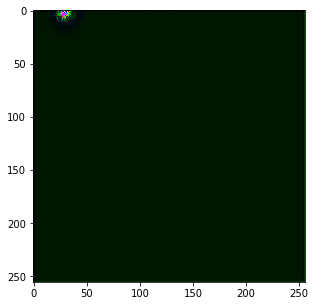

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(image_out[0,:,:,:])

# Appendix A: Loading parameters from pytorch

Now that we have a model: Lets load the OpenAI pretrained weights, and see if we match up! This part breaks if you run the JIT because the order seems to not match anymore, so... don't, or do something smarter than just going by order.

In [ ]:
# Helper function to build a list of param entries (and print them besides)
def traverse_params(params, prefix = "", name_prefix = "", print_params=False):
    param_sum = 0
    param_list = []
    for key in params.keys():
        if isinstance(params[key], flax.core.frozen_dict.FrozenDict) or isinstance(params[key], dict):
            if print_params:
                print(prefix + key)
            param_sum_rec, param_list_rec = traverse_params(params[key], prefix + "    ", name_prefix + key + ".", print_params)
            param_sum += param_sum_rec
            param_list.extend(param_list_rec)
        else:
            if print_params:
                print(prefix + key, params[key].shape)            
            param_sum += (params[key].flatten().shape[0])
            param_list.append((name_prefix + key, params[key].shape))
    return param_sum, param_list

In [ ]:
param_sum, param_list = traverse_params(params)
print("Number of parameters:", param_sum)

Number of parameters: 552814086


In [ ]:
# Import pytorch, download the 256x256 unconditional model, and load the state dictionary
import torch as pt
!wget https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt
state_dict = pt.load("/content/256x256_diffusion_uncond.pt", map_location=pt.device("cpu"))

--2021-07-31 18:59:57--  https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.150.77.132
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.150.77.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2211383297 (2.1G) [application/octet-stream]
Saving to: ‘256x256_diffusion_uncond.pt’

256x256_diffusion_u 100%[===================>]   2.06G  45.1MB/s    in 47s     

2021-07-31 19:00:44 (45.1 MB/s) - ‘256x256_diffusion_uncond.pt’ saved [2211383297/2211383297]



In [ ]:
# See if shapes match up and build a list of parameters to assign
param_dict = {}
for (jax_key, jax_shape), torch_key in zip(param_list, state_dict.keys()):
    pt_shape = tuple(state_dict[torch_key].shape[::-1])
    while len(pt_shape) < len(jax_shape):
        pt_shape = (1,) + pt_shape
    param_dict[jax_key] = state_dict[torch_key].T.reshape(pt_shape).detach().numpy()
    if jax_shape != param_dict[jax_key].shape:
        print("Shape mismatch:", jax_key, jax_shape, torch_key, pt_shape)

In [ ]:
# Traverse unfrozen version of params and assign according to keys from traverse_params
def assign_params(params, param_dict, name_prefix = ""):
    for key in params.keys():
        if isinstance(params[key], dict):
            assign_params(params[key], param_dict, name_prefix + key + ".")
        else:
            params[key] = param_dict[name_prefix + key]
params_load = params.unfreeze()            
assign_params(params_load, param_dict)

In [ ]:
# Now, save the result
with open("openai_256x256_diffusion_uncond.pkl", "wb") as f:
    pickle.dump(params_load, f)

In [ ]:
# And copy it to somewhere safe
from google.colab import drive
drive.mount('/content/drive')
!cp openai_256x256_diffusion_uncond.pkl /content/drive/MyDrive/openai_256x256_diffusion_uncond.pkl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Appendix B: Rename weights after flax.linen.jit (Maybe don't use that, though)

In [ ]:
# Build a flat dictionary for easy renaming
def build_flat_dict(params, prefix = "", name_prefix = "", print_params=False):
    param_sum = 0
    param_list = []
    for key in params.keys():
        if isinstance(params[key], flax.core.frozen_dict.FrozenDict) or isinstance(params[key], dict):
            if print_params:
                print(prefix + key)
            param_sum_rec, param_list_rec = build_flat_dict(params[key], prefix + "    ", name_prefix + key + ".", print_params)
            param_sum += param_sum_rec
            param_list.extend(param_list_rec)
        else:
            if print_params:
                print(prefix + key, params[key].shape)            
            param_sum += (params[key].flatten().shape[0])
            param_list.append((name_prefix + key, params[key] ))
    
    if name_prefix == "":
        param_list = dict(param_list)

    return param_sum, param_list

param_sum, param_list = traverse_params(params)
print("Number of parameters:", param_sum)

param_sum_load, param_list_load = build_flat_dict(params_load)
print("Number of parameters (loaded):", param_sum_load)

Number of parameters: 552814086
Number of parameters (loaded): 552814086


In [ ]:
# Make sure our renaming gets everything
for param in param_list:
    param_name = param[0]
    param_name_loaded = param_name.replace("Jit", "")
    if not param_name_loaded in param_list_load:
        print("MISSING")

In [ ]:
# Traverse unfrozen version of params and assign according to keys from traverse_params
def assign_params_rename(params, param_dict, name_prefix = ""):
    for key in params.keys():
        if isinstance(params[key], dict):
            assign_params_rename(params[key], param_dict, name_prefix + key + ".")
        else:
            param_name = name_prefix + key
            param_name_loaded = param_name.replace("Jit", "")
            params[key] = param_dict[param_name_loaded]
params_load_renamed = params.unfreeze()            
assign_params_rename(params_load_renamed, param_list_load)

In [ ]:
# Now, save the result
with open("openai_256x256_diffusion_uncond_jit.pkl", "wb") as f:
    pickle.dump(params_load_renamed, f)

In [ ]:
# And copy it to somewhere safe
from google.colab import drive
drive.mount('/content/drive')
!cp openai_256x256_diffusion_uncond_jit.pkl /content/drive/MyDrive/openai_256x256_diffusion_uncond.pkl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Next up
Tomorrow, we continue where we left off: Lets implement the whole unet, maybe train something!